<a href="https://colab.research.google.com/github/viniciusvmda/procedural-texture/blob/master/gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programação Genética
https://www.pyimagesearch.com/2014/07/14/3-ways-compare-histograms-using-opencv-python/

## Requisitos

In [0]:
# GP
!pip install deap
# Graphics
!apt-get install graphviz libgraphviz-dev pkg-config
!pip install pygraphviz networkx
# Noise functions
!pip install noise
# Pattern generation
!pip install imagen

## Bibliotecas

In [0]:
# Genetic Programming
from deap import base, creator, gp, tools, algorithms
# Graphics
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt
# Computer vision
import cv2
from google.colab.patches import cv2_imshow
# Util
import numpy as np
import random
# Operators
from noise import snoise2
# Upload images
from google.colab import files
from io import BytesIO
# Pattern generation
import imagen as ig

## Desenvolvimento

### Inicialização de variáveis

In [0]:
toolbox = base.Toolbox()

#### Imagem de referência

In [59]:
files.upload()

Saving ruined-texture.jpg to ruined-texture (1).jpg


{'ruined-texture.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\x00\x01\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x03\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x04\x05\x06\x02\x01\x00\x07\xff\xc4\x00;\x10\x00\x02\x02\x01\x03\x02\x05\x02\x04\x04\x06\x02\x03\x01\x00\x03\x01\x02\x03\x11\x04\x00\x12!1A\x05\x13"Qaq\x81\x142\x91\xa1#B\xb1\xc1\x06\x15R\xd1\xe1\xf0$3Cb\xf1r5\x82\xa2\xff\xc4\x00\x18\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x02\x03\x04\xff\xc4\x00\x1e\x11\x01\x01\x01\x00\x02\x02\x03\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x11!1\x02A\x12Qaq\xff\xda\x00\x0c\x03\x01

In [0]:
BASE_IMG = cv2.imread('ruined-texture.jpg')

BASE_IMG_WIDTH = BASE_IMG.shape[0];
BASE_IMG_HEIGHT = BASE_IMG.shape[1];
NUMBER_OF_CHANNELS = 3
BGR_MAX = 255;

WHITE_IMG = np.full((BASE_IMG_WIDTH,BASE_IMG_HEIGHT, NUMBER_OF_CHANNELS), BGR_MAX, dtype=np.uint8)

### Util

In [0]:
def plotTree(expr):
  nodes, edges, labels = gp.graph(expr)
  
  g = nx.DiGraph()
  g.add_nodes_from(nodes)
  g.add_edges_from(edges)
  pos = graphviz_layout(g, prog="dot")

  nx.draw_networkx_nodes(g, pos)
  nx.draw_networkx_edges(g, pos)
  nx.draw_networkx_labels(g, pos, labels)
  
  plt.show()


def plotImage(data):
  plt.axis("off")
  plt.imshow(data, cmap='binary')

  
def convertFloatToUint8(img):
  return cv2.normalize(img, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8UC3);



### Algoritmo

#### Operadores

In [0]:
# https://docs.opencv.org/3.0-beta/modules/imgproc/doc/filtering.html
# https://docs.opencv.org/3.2.0/d0/d86/tutorial_py_image_arithmetics.html
# Simplex noise
def perlinNoise(scale=100, octaves=6):
  octavesNormalized = octaves % 6 + 1
  output = np.zeros((BASE_IMG_WIDTH, BASE_IMG_HEIGHT), dtype=np.float)
  for x in range(0, BASE_IMG_WIDTH):
    for y in range(0, BASE_IMG_HEIGHT):
        noiseValue = snoise2(x/scale, y/scale, octaves=octavesNormalized, base=0)
        output[x][y] = noiseValue
  outputUint8 = convertFloatToUint8(output)
  return cv2.cvtColor(outputUint8, cv2.COLOR_GRAY2BGR)

# Patterns generators
tiles = ig.SquareGrating()

def createTiles(numberOfTiles, orientation):
  MAX_NUMBER_OF_TILES = 10
  img = tiles(xdensity=BASE_IMG_WIDTH, ydensity=BASE_IMG_HEIGHT, phase=np.pi/2, frequency=numberOfTiles % MAX_NUMBER_OF_TILES, orientation=orientation)
  imgUint8 = convertFloatToUint8(img)
  return cv2.cvtColor(imgUint8, cv2.COLOR_GRAY2BGR)


def createChessBoard(numberOfLines):
  horizontal = np.where(createTiles(numberOfLines, 0) == 255, 1, 0)
  vertical = np.where(createTiles(numberOfLines, np.pi/2) == 255, 1, 0)
  output = np.where(horizontal + vertical > 1, 255, 0)
  return np.uint8(output)


def addWeighted(img1, img2, weight):
  GAMMA = 0
  return cv2.addWeighted(img1, weight, img2, 1 - weight, GAMMA)

#### Fitness

In [0]:
def calculateHistogram(img):
  channels = [0, 1, 2]
  mask = None
  binsPerChannel = [8, 8, 8]
  rangesPerDimension = [0, 256, 0, 256, 0, 256]
  
  hist = cv2.calcHist([img], channels, mask, binsPerChannel, rangesPerDimension)
  hist = cv2.normalize(hist, hist).flatten()
  
  return hist;


def compareHistograms(img1, img2):
  hist1 = calculateHistogram(img1)
  hist2 = calculateHistogram(img2)
  d = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
  # d está no intervalo [0, 1]
  return d


def evalFitness(individual):
  # Transform the tree expression in a callable function
  img = toolbox.compile(expr=individual)
  return compareHistograms(BASE_IMG, img), # must return a tuple containing one element

#### Estrutura da árvore

In [61]:
#https://gist.github.com/macrintr/9876942

def _(a):
    return a

def rand100():
  return random.randrange(100) + 1

  # Define input types and output type
pset = gp.PrimitiveSetTyped("main", [], np.ndarray)

# Add operators
pset.addPrimitive(perlinNoise, [int, int], np.ndarray)
pset.addPrimitive(createTiles, [int, float], np.ndarray)
pset.addPrimitive(createChessBoard, [int], np.ndarray)
pset.addPrimitive(addWeighted, [np.ndarray, np.ndarray, float], np.ndarray)

pset.addPrimitive(_, [float], float)
pset.addPrimitive(_, [int], int)

pset.addTerminal(WHITE_IMG, np.ndarray, "blank")

pset.addTerminal(100, int)
pset.addTerminal(80, int)
pset.addTerminal(60, int)
pset.addTerminal(40, int)
pset.addTerminal(20, int)

pset.addTerminal(0.0, float)
pset.addTerminal(0.1, float)
pset.addTerminal(0.2, float)
pset.addTerminal(0.3, float)
pset.addTerminal(0.4, float)
pset.addTerminal(0.5, float)


# Create individual and add tree with primitives
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, pset=pset, fitness=creator.FitnessMax)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=4, max_=20)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

# Fitness Evaulation
toolbox.register("evaluate", evalFitness)
# Selection
toolbox.register("select", tools.selTournament, tournsize=3)
# Crossover
toolbox.register("mate", gp.cxOnePoint)
# Mutation
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


#### Testes

In [71]:
N_HALL_OF_FAME_INDIVIDUALS = 1
INITIAL_POPULATION_SIZE = 20
CROSSOVER_PROBABILITY = 0.6
MUTATION_PROBABILITY = 0.1
N_GENERATIONS = 10

random.seed(10)
pop = toolbox.population(n=INITIAL_POPULATION_SIZE)
hof = tools.HallOfFame(N_HALL_OF_FAME_INDIVIDUALS)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

algorithms.eaSimple(pop, toolbox, CROSSOVER_PROBABILITY, MUTATION_PROBABILITY, N_GENERATIONS, stats, halloffame=hof)

gen	nevals	avg        	std       	min       	max        
0  	20    	-0.00720304	0.00104032	-0.0084641	-0.00602754
1  	15    	-0.00637786	0.000709074	-0.00805255	-0.00602754
2  	11    	-0.00602754	0          	-0.00602754	-0.00602754
3  	12    	-0.00602754	0          	-0.00602754	-0.00602754
4  	10    	-0.00602754	0          	-0.00602754	-0.00602754
5  	17    	-0.00602754	0          	-0.00602754	-0.00602754
6  	9     	-0.00602754	0          	-0.00602754	-0.00602754
7  	15    	-0.00602754	0          	-0.00602754	-0.00602754
8  	10    	-0.00605611	0.000124572	-0.00659911	-0.00602754
9  	16    	-0.00602754	0          	-0.00602754	-0.00602754
10 	9     	-0.00602754	0          	-0.00602754	-0.00602754


([[<deap.gp.Primitive at 0x7fb82dfb8228>,
 [{'avg': -0.0072030433065314245,
   'gen': 0,
   'max': -0.00602753514097576,
   'min': -0.008464099326023808,
   'nevals': 20,
   'std': 0.001040321778301614},
  {'avg': -0.006377862458713264,
   'gen': 1,
   'max': -0.00602753514097576,
   'min': -0.00805254828512286,
   'nevals': 15,
   'std': 0.0007090744365459695},
  {'avg': -0.00602753514097576,
   'gen': 2,
   'max': -0.00602753514097576,
   'min': -0.00602753514097576,
   'nevals': 11,
   'std': 0.0},
  {'avg': -0.00602753514097576,
   'gen': 3,
   'max': -0.00602753514097576,
   'min': -0.00602753514097576,
   'nevals': 12,
   'std': 0.0},
  {'avg': -0.00602753514097576,
   'gen': 4,
   'max': -0.00602753514097576,
   'min': -0.00602753514097576,
   'nevals': 10,
   'std': 0.0},
  {'avg': -0.00602753514097576,
   'gen': 5,
   'max': -0.00602753514097576,
   'min': -0.00602753514097576,
   'nevals': 17,
   'std': 0.0},
  {'avg': -0.00602753514097576,
   'gen': 6,
   'max': -0.006027535

addWeighted(perlinNoise(_(_(_(80))), _(_(80))), createChessBoard(_(_(_(60)))), _(_(_(_(0.1)))))


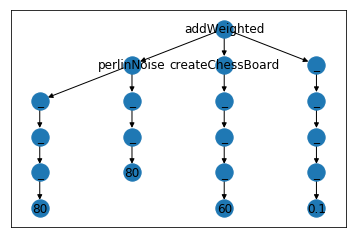

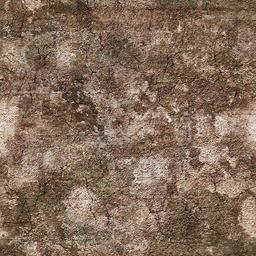

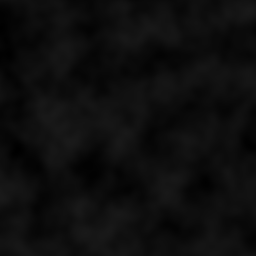

In [72]:
tree = gp.PrimitiveTree(hof[0])
compiledExpression = gp.compile(tree, pset)

print(hof[0])
plotTree(hof[0])
cv2_imshow(BASE_IMG)
cv2_imshow(compiledExpression)
